In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from openpyxl.utils import dataframe
from scipy import stats

# analysis of the words
import string
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords

# Download the stopwords if you haven't already (you need to run this once)
import nltk
nltk.download('stopwords')

#  Custom importations
from helper.helper import proportion_balance_classes, extractions_text_description, histogram_bins

import warnings

#enable the block of code
enable_code = False

%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importation and preprocessing

In [2]:
df_train_full = pd.read_csv("datasets/train.csv")
df_test = pd.read_csv("datasets/test.csv")
df_train_full.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


Verify the types of the columns

In [3]:
df_train_full.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

Seems that we had the correct types on each of the columns and now we will be verifying the duplicated and NA values 

In [4]:
df_train_full.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
df_train_full_clean = df_train_full.dropna()

no null values then we will be cheking for duplicated values in the id

In [6]:
len(df_train_full_clean["id"].unique()) == df_train_full_clean.shape[0]

True

In [7]:
df_train_full_clean.duplicated().sum()

0

Seems that we dont find any duplicates in the values

In [8]:
df_train_full_clean = df_train_full_clean.drop(columns=["id"])

In [9]:
df_train_full_clean.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


we will be cheking the distribution and proportion of the datasets

In [10]:
nrow_train = df_train_full_clean.shape[0]
nrow_test = df_test.shape[0]
sum_rows = nrow_train + nrow_test

data_proportions = {
    'Type': ['Train', 'Test'],
    'Rows': [nrow_train, nrow_test],
    'Percentage': [round(nrow_train * 100 / sum_rows), round(nrow_test * 100 / sum_rows)]
}

# Converting to pandas DataFrame
df_summary = pd.DataFrame(data_proportions)
df_summary

,Type,Rows,Percentage
0,Train,159571,51
1,Test,153164,49


Mostly the same quantity of values that we had,
now the next step would be to try to undestand the imbalance of the data, to define what strategy we need to manage

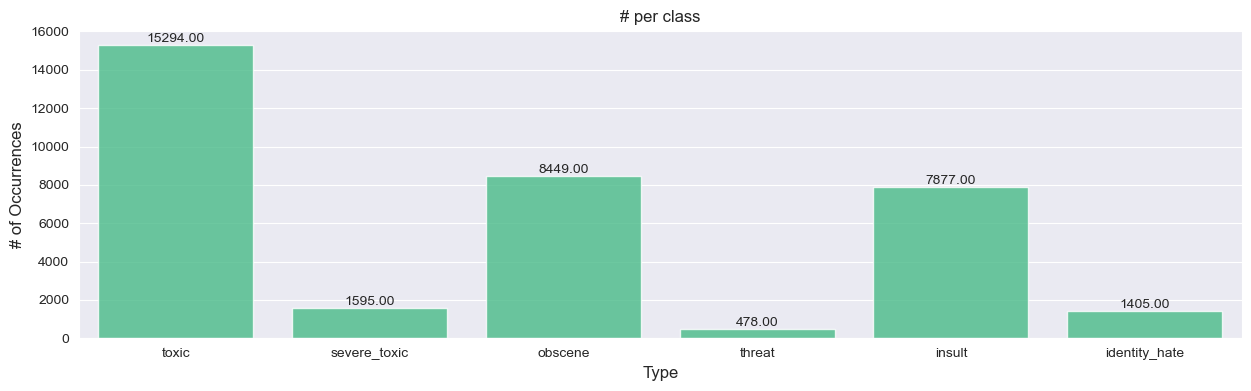

In [11]:
target_y =df_train_full_clean.iloc[:,1:].sum()
proportion_balance_classes(target_y.index, target_y.values)

As we could see the data its complitly imbalance,
so probably we could try
to manage
using any of the technics
that we know like SMOTE or undersampling to modify the dataset so we could get a better performance in the results.
Also now we will be seeing the proportions of the independent variables.

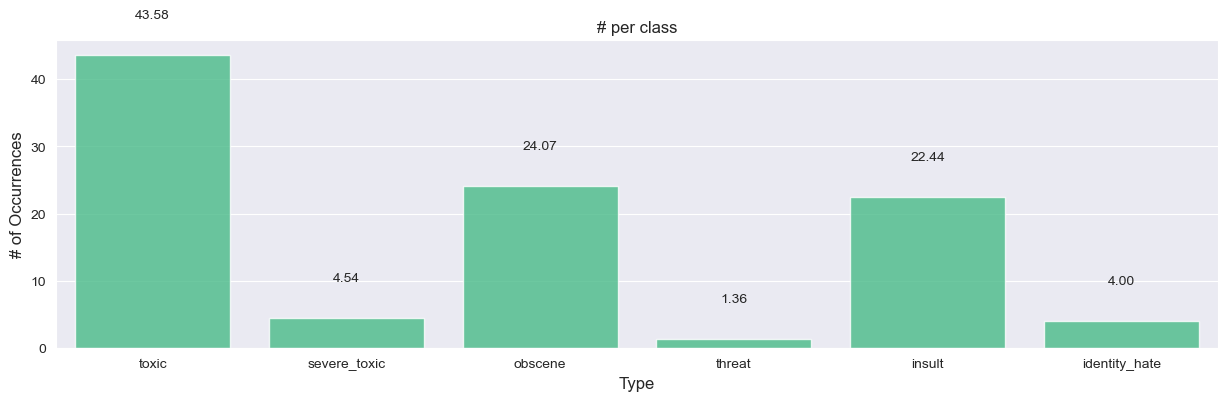

In [12]:
total_sum = target_y.sum()
proportions = (target_y / total_sum) * 100

proportion_balance_classes(proportions.index, proportions.values)

We could see
that in some classes we had mostly 43% of the cases and in cases lkie sever_toxic or threat we had less cases
so this could impact the total cases;
Now we will see how much of the total cases we had that are kind of toxic and which cases are not toxic at all, for that we will take into account if at least one of the values had a comment we will be consider this as a problem to out toxic comment.

In [13]:
df_train_full_clean['is_toxic'] = (df_train_full_clean.iloc[:, 1:].sum(axis=1) > 0).astype(int)
toxic_comments = df_train_full_clean['is_toxic'].sum()

print(f"We had {df_train_full_clean.shape[0]} comments but from that we had just {toxic_comments} toxic comments so we could see the next proportions, {toxic_comments / df_train_full_clean.shape[0]} % in total to know the toxic comments")


We had 159571 comments but from that we had just 16225 toxic comments so we could see the next proportions, 0.10167887648758234 % in total to know the toxic comments


So we could see that we had just 10% of the total of comments to be toxic,
so defintly we will need to apply any kind of balancing to get a better performance in the data.

Now we will be seeing
how many of those total comments had multiple tags in the comments
to understand correctly if we can had several target variables in the same comment 

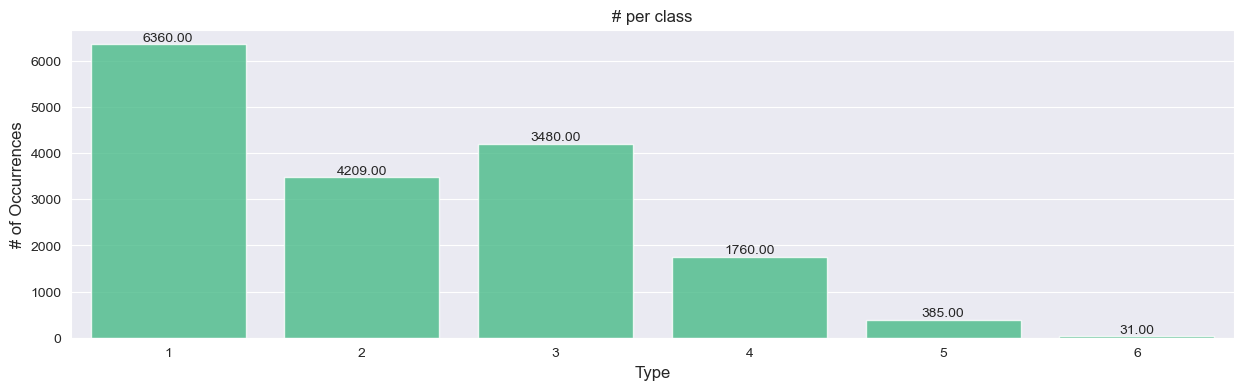

In [14]:
rowsums = df_train_full_clean.drop(['is_toxic'], axis=1)
rowsums= rowsums.iloc[:,1:].sum(axis=1)
rowsums_count_values = rowsums.value_counts()
rowsums_count_values = rowsums_count_values[rowsums_count_values < rowsums_count_values.max()]

proportion_balance_classes(rowsums_count_values.index, rowsums_count_values.values)


As we can see we had mostly of the hashtags target with just one comments and the most comment
we had  probably the toxic it is,
so we will try
to see if we could try to plot each of the comment types to see what kind of data we had on the classes we see above.

Now we will try to see if we found any association between the target variables.

# Does the likelihood of each feature are associated in any form?

- **Null Hypothesis (H0):** We have a significant relationship between the both variables
        $$p-value > 5%$$
- **Alternative Hypothesis (Ha):** There is a difference between the distributions 
        $$p-value < 5%$$

In [15]:
verify_association_df = df_train_full_clean.iloc[:,1:].drop(columns=['is_toxic'], axis=1)
columns_names = verify_association_df.columns

results_list = []

for i, col1 in enumerate(columns_names):
    for col2 in columns_names[i+1:]:
        
        proportion = pd.crosstab(verify_association_df[col1], verify_association_df[col2])     
        chi2, p, dof, expected = stats.chi2_contingency(proportion)
        expected_vals = pd.DataFrame(expected)
        
        result = {
                'Variable 1': col1,
                'Variable 2': col2,
                'Chi2': chi2,
                'p-value': p,
                'Degrees of Freedom': dof
            }
        results_list.append(result)

results_df = pd.DataFrame(results_list)
results_df

,Variable 1,Variable 2,Chi2,p-value,Degrees of Freedom
0,toxic,severe_toxic,15187.921990,0.0,1
1,toxic,obscene,73020.900433,0.0,1
2,toxic,threat,3926.436082,0.0,1
3,toxic,insult,66894.731374,0.0,1
4,toxic,identity_hate,11281.731428,0.0,1
5,severe_toxic,obscene,25899.536995,0.0,1
6,severe_toxic,threat,2415.127564,0.0,1
7,severe_toxic,insult,22518.938230,0.0,1
8,severe_toxic,identity_hate,6463.712093,0.0,1
9,obscene,threat,3168.966146,0.0,1


We reject the null hypothesis.
There is a difference between the distributions;
means that the frequency of categories in one variable is not evenly distributed across the categories of the other variable

Now we will see some comments that are toxic to understand what we are handling to.
After ploting some examples we will be analysing whats happening

In [16]:
feature_to_review = "toxic"
example_comment = df_train_full_clean[df_train_full_clean[feature_to_review] == 1].iloc[0:3, 0]

for index, rows in example_comment.items():
    print(f"Example of {feature_to_review} comment: {index}")
    print(rows)
    print("---------")


Example of toxic comment: 6
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
---------
Example of toxic comment: 12
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
---------
Example of toxic comment: 16
Bye! 

Don't look, come or think of comming back! Tosser.
---------


In [17]:
feature_to_review = "severe_toxic"
example_comment = df_train_full_clean[df_train_full_clean[feature_to_review] == 1].iloc[0:3, 0]

for index, rows in example_comment.items():
    print(f"Example of {feature_to_review} comment: {index}")
    print(rows)
    print("---------")


Example of severe_toxic comment: 6
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
---------
Example of severe_toxic comment: 55
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
---------
Example of severe_toxic comment: 181
you are a stupid fuck 

and your mother's cunt stinks
---------


In [18]:
feature_to_review = "obscene"
example_comment = df_train_full_clean[df_train_full_clean[feature_to_review] == 1].iloc[0:3, 0]

for index, rows in example_comment.items():
    print(f"Example of {feature_to_review} comment: {index}")
    print(rows)
    print("---------")


Example of obscene comment: 6
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
---------
Example of obscene comment: 42
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
---------
Example of obscene comment: 43
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
---------


In [19]:
feature_to_review = "threat"
example_comment = df_train_full_clean[df_train_full_clean[feature_to_review] == 1].iloc[0:3, 0]

for index, rows in example_comment.items():
    print(f"Example of {feature_to_review} comment: {index}")
    print(rows)
    print("---------")


Example of threat comment: 79
Hi! I am back again!
Last warning!
Stop undoing my edits or die!
---------
Example of threat comment: 176
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms
---------
Example of threat comment: 600
I'm also a sock puppet of this account...SUPRISE!!
-sincerely,
            The man that will track you down from the Internet and kill you
---------


In [20]:
feature_to_review = "insult"
example_comment = df_train_full_clean[df_train_full_clean[feature_to_review] == 1].iloc[12:15, 0]

for index, rows in example_comment.items():
    print(f"Example of {feature_to_review} comment: {index}")
    print(rows)
    print("---------")


Example of insult comment: 211
Fuck you, block me, you faggot pussy!
---------
Example of insult comment: 218
Kill all niggers. 

I have hard, that others have said this.. should this be included? That racists sometimes say these.
---------
Example of insult comment: 231
Burn Deck 

If that'd guy's burn deck is like what I think it is than he is in for a blrude awakening!!! Leviathan motherfucker!!!
---------


In [21]:
feature_to_review = "identity_hate"
example_comment = df_train_full_clean[df_train_full_clean[feature_to_review] == 1].iloc[5:8, 0]

for index, rows in example_comment.items():
    print(f"Example of {feature_to_review} comment: {index}")
    print(rows)
    print("---------")


Example of identity_hate comment: 429
Gay 

The existence of CDVF is further proof that  is a sad twat. He is also very ugly, and has a willy for a face.
---------
Example of identity_hate comment: 521
Dictionaries

How dare you call my contribution spam!!! I am a Kurd and I made a lsit of kurdish dictionaries. you bloody turkish nationalist and atoricity commiting bone breaking Nazi. watch out folk this slimy Turk is trying to censor the internet this is not undemocratic Turkey here, no prison cells in wikipedia you stupid Turk! And you buggers want membership to the EEC
---------
Example of identity_hate comment: 887
you gay motherfucker i know where you live,i am going to sand your face off,then i am to going to beat you to a pulp,you chicken shagger.
---------


The comments are offensive and contain complex topics, instances of hate speech, and some bad words.

To better understand the data, we will extract features such as the length of values, character types, and other relevant metrics. This will help us gain valuable insights and uncover patterns within the data.

In [22]:
df_add_features = extractions_text_description(df_train_full_clean, "comment_text")
df_add_features

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,count_each_word,count_unique_word,...,total_length,new_line,new_small_space,new_medium_space,new_big_space,uppercase_words,question_mark,exclamation_mark,word_unique_percent,punctuations_percent
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,41,...,264,1,0,0,0,17,1,0,95.348837,23.255814
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,17,...,112,0,0,0,0,8,0,1,100.000000,70.588235
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,39,...,233,0,0,0,0,4,0,0,92.857143,14.285714
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,82,...,622,4,1,0,0,11,0,0,72.566372,18.584071
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,13,...,67,0,0,0,0,2,1,0,100.000000,38.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0,47,44,...,295,2,1,0,0,2,2,0,93.617021,38.297872
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0,18,18,...,99,2,1,0,0,2,0,0,100.000000,22.222222
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0,12,12,...,81,2,1,0,0,4,0,0,100.000000,33.333333
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,0,25,23,...,116,0,0,0,0,2,0,0,92.000000,4.000000


finally this are all the features that we add to the dataframe

In [23]:
df_add_features.columns.difference(df_train_full_clean.columns)

Index(['count_each_word', 'count_punctuations', 'count_stopwords',
       'count_unique_word', 'count_words_title', 'exclamation_mark',
       'mean_word_len', 'new_big_space', 'new_line', 'new_medium_space',
       'new_small_space', 'punctuations_percent', 'question_mark',
       'total_length', 'uppercase_words', 'word_unique_percent'],
      dtype='object')

The next step is to visualize each of the values to understand how they behave.

In [24]:
np.mean(df_add_features["count_each_word"])

67.27352714465661

We had several possibilities in the quantity of words on each value
for that we will try to plot the values in bins to understand the distribution better. 

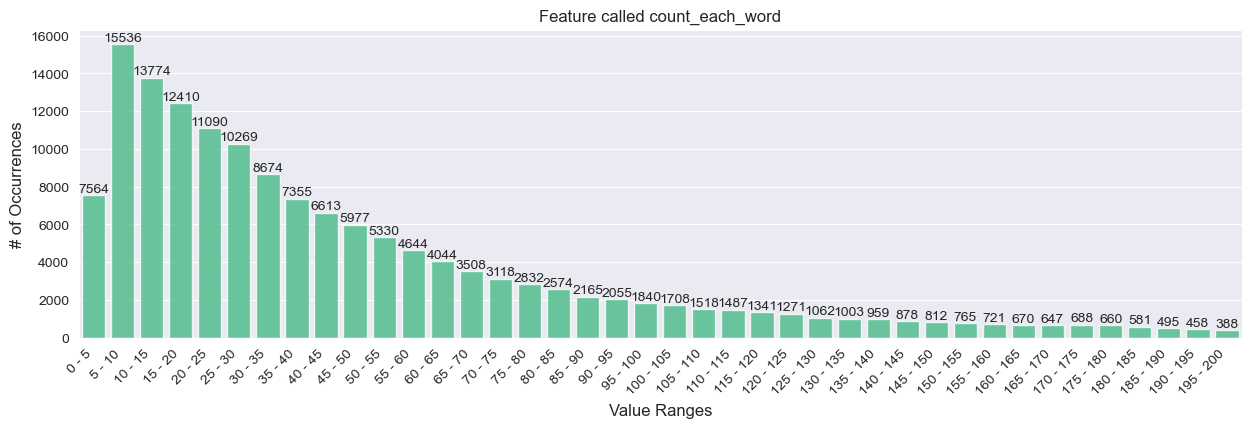

In [25]:
column_select = "count_each_word"
# we filter it because if not we will see too many outliers
filter_data = df_add_features[df_add_features[column_select] <= 200]
histogram_bins(filter_data[column_select].index, filter_data[column_select].values,bins= 40, title= f"Feature called {column_select}" )

We understand that most of the words  in the dataset are around 5,
so we will try to see if we can spot any idea when applying the filter if there is toxic comment

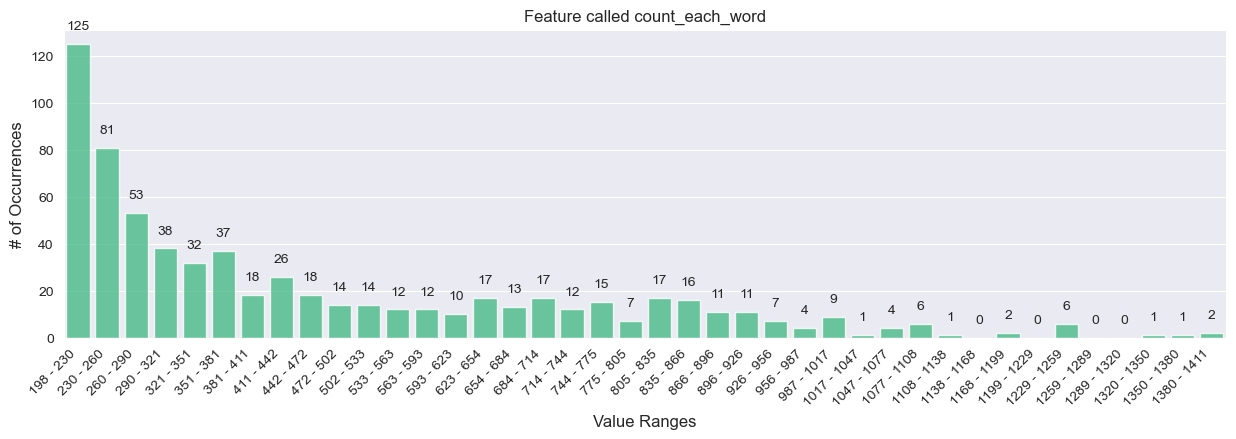

In [26]:
column_select = "count_each_word"
# we filter it because if not we will see too many outliers
filter_data = df_add_features[(df_add_features[column_select] >= 200) & (df_add_features["is_toxic"] == 1)]
histogram_bins(filter_data[column_select].index, filter_data[column_select].values,bins= 40, title= f"Feature called {column_select}" )

Seems that they had similar distributions for that we can plot a box plot and see if we could spot any differences

In [27]:
column_select = "count_punctuations"
df_filter = df_add_features[column_select].value_counts()
print(f"we had around {round(df_filter.head(10).sum() / df_filter.sum(),4)*100} % of the data")
df_filter

we had around 55.58 % of the data


count_punctuations
3      11463
2      10995
4      10693
5       9962
6       9173
       ...  
449        1
417        1
685        1
439        1
714        1
Name: count, Length: 381, dtype: int64

We can just see fewer punctuation on mostly of the data

We could not spot any significance on the unique words that the titles could had

In [28]:
df_add_features.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,count_each_word,count_unique_word,count_punctuations,...,total_length,new_line,new_small_space,new_medium_space,new_big_space,uppercase_words,question_mark,exclamation_mark,word_unique_percent,punctuations_percent
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,...,159571.000000,159571.00000,159571.000000,159571.000000,159571.000000,159571.000000,159571.00000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.101679,67.273527,48.097323,15.885418,...,394.073221,2.52074,0.900201,0.000846,0.000269,17.159628,0.44928,0.661624,85.501925,30.130164
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226,99.230702,54.436443,36.649770,...,590.720282,5.96225,2.072427,0.034223,0.018898,96.528103,1.58990,25.899553,12.817618,201.474287
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,6.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.080000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,16.000000,4.000000,...,96.000000,0.00000,0.000000,0.000000,0.000000,3.000000,0.00000,0.000000,77.906977,14.814815
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,31.000000,8.000000,...,205.000000,1.00000,0.000000,0.000000,0.000000,7.000000,0.00000,0.000000,87.500000,21.739130
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,59.000000,17.000000,...,435.000000,2.00000,1.000000,0.000000,0.000000,15.000000,1.00000,0.000000,95.652174,33.159258
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1411.000000,816.000000,4942.000000,...,5000.000000,312.00000,122.000000,4.000000,3.000000,4960.000000,209.00000,4942.000000,100.000000,70600.000000


We try to find any pattern that can suggest any idea of whats happening if we use different methods,
but overall, i could not detect any clear pattern.

Now we will stop the 1st part of the analysis in local, so we will be moving to the cloud.

# Conclusions

- We see a really imbalance dataset, so we will need to play with any of the under sampling or oversampling technics to balance the dataset or use weights, but for now
- We found that across characters, length or words, there its not an specific patter that it can suggest any predictability from our analysis, so we will move to more complex analysis